In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as F

# ========== 1. Set Up Paths and Transforms ==========
data_dir = 'Covid19-dataset'

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [4]:
# ========== 2. Load Datasets ==========
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))
print("Classes:", class_names)

# ========== 3. Device Config ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Train size: 251
Test size: 66
Classes: ['Covid', 'Normal', 'Viral Pneumonia']


In [5]:
# ========== 4. Define Custom CNN (Optional) ==========
class CustomCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 56, 56]
        x = x.view(-1, 64 * 56 * 56)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# ========== 5. Initialize Custom Model ==========
model = CustomCNN(num_classes=len(class_names)).to(device)

# ========== 6. Loss and Optimizer ==========
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [10]:
# ========== 7. Train the Model ==========
num_epochs = 10
train_losses, train_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch [1/10] - Loss: 0.2925, Accuracy: 0.8845
Epoch [2/10] - Loss: 0.2618, Accuracy: 0.9124
Epoch [3/10] - Loss: 0.2324, Accuracy: 0.9163
Epoch [4/10] - Loss: 0.2224, Accuracy: 0.9163
Epoch [5/10] - Loss: 0.2222, Accuracy: 0.9124
Epoch [6/10] - Loss: 0.2252, Accuracy: 0.9163
Epoch [7/10] - Loss: 0.1620, Accuracy: 0.9323
Epoch [8/10] - Loss: 0.1827, Accuracy: 0.9283
Epoch [9/10] - Loss: 0.1786, Accuracy: 0.9442
Epoch [10/10] - Loss: 0.1638, Accuracy: 0.9402


In [11]:
# ========== 8. Evaluate on Test Set ==========
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ========== 9. Accuracy ==========
test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\nTest Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8939


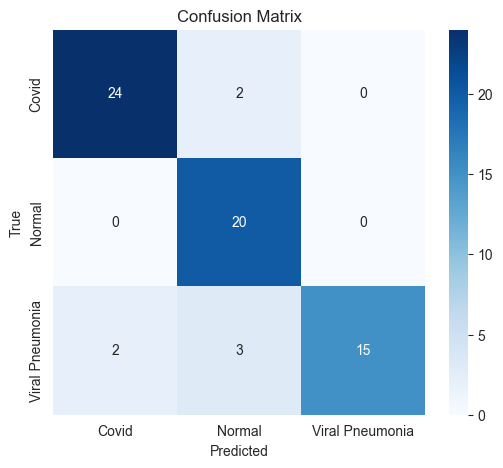


Classification Report:
                 precision    recall  f1-score   support

          Covid       0.92      0.92      0.92        26
         Normal       0.80      1.00      0.89        20
Viral Pneumonia       1.00      0.75      0.86        20

       accuracy                           0.89        66
      macro avg       0.91      0.89      0.89        66
   weighted avg       0.91      0.89      0.89        66



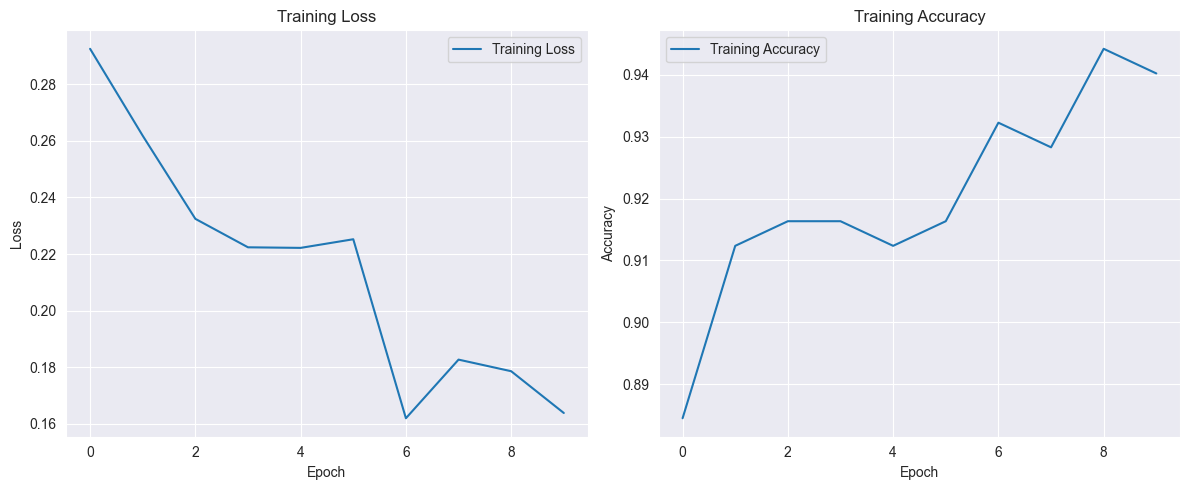

In [12]:
# ========== 10. Confusion Matrix ==========
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ========== 11. Classification Report ==========
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ========== 12. Plot Loss and Accuracy ==========
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()